
# **SER Tecnicas de Data Augmentation**

## English
El siguiente analisis presenta una clasificacion emocional del discurso, reconociendo 7 emociones (enfado, sorpresa, asco, miedo, felicidad, tristeza y neutral) para el idioma **ingles**.

Luisa Sanchez Avivar
    _luisasanavi@gmail.com_

In [38]:
# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils, to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile



In [39]:
AUDIO_DATA_PATH = 'data/'
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'
SAMPLE_FILE = "03-01-01-01-01-01-01.wav"

# Maps
EMOTION_MAP = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}


## **1. CARGA DE DATOS**
Para este analisis utilizare el dataset de [RAVDESS](https://zenodo.org/record/1188976.) (Ryerson Audio-Visual Database of Emotional Speech and Song), el cual contiene 7356 archivos (24.8 GB) entre los cuales podemos encontrar 3 modalidades: **solo audio** (en 16 bit, 48 kHz y en formato .wav), **audio-video** (720p H.264, AAC 48kHz, .mp4) y **solo video** sin sonido.





In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
dir_list = os.listdir(GPATH + AUDIO_DATA_PATH)
dir_list.sort()

print(dir_list)

emotion = []
gender = []
intensity = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in dir_list:
  path_dir = os.listdir(GPATH + AUDIO_DATA_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    n_gender = int(info_vector[6])
    n_intensity = int(info_vector[3])
    str_path = GPATH + AUDIO_DATA_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)
    intensity.append(n_intensity)
    if n_gender%2 == 0:
      gender.append('female')
    else:
      gender.append('male')

# Construimos el data frame
EnglishSpeech_df = pd.DataFrame(columns=['emotion', 'gender', 'intensity', 'path'])
EnglishSpeech_df['emotion'] = emotion
EnglishSpeech_df['gender'] = gender
EnglishSpeech_df['intensity'] = intensity
EnglishSpeech_df['path'] = path
EnglishSpeech_df['emotion'] = EnglishSpeech_df['emotion'].map(EMOTION_MAP) 
EnglishSpeech_df['intensity'] = EnglishSpeech_df['intensity'].map(INTENSITY_MAP)


print("Size of the dataset: {} \n".format(len(EnglishSpeech_df)))
class_distribution = EnglishSpeech_df['emotion'].value_counts()
print(class_distribution)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24', 'RAVDESS']
Size of the dataset: 1440 

surprise    192
fear        192
sad         192
angry       192
disgust     192
happy       192
calm        192
neutral      96
Name: emotion, dtype: int64


In [7]:
# Imprimimos una muestra de 10 filas aleatorias
EnglishSpeech_df.sample(n = 10)

,emotion,gender,intensity,path
857,happy,male,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
156,fear,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
375,happy,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
337,angry,female,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
473,surprise,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
460,fear,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
524,disgust,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
1359,fear,male,normal,/content/drive/My Drive/Master/Asignaturas/2 C...
232,disgust,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...
806,sad,female,strong,/content/drive/My Drive/Master/Asignaturas/2 C...


# **2. EXPLORACION DE LOS DATOS**

### **2.1 EXPOSICION DE UNA MUESTRA ALEATORIA**



In [8]:

def plot_audio_waveform(audio_sample):
  '''
  Muestra la forma de la onda sonora a partir de una muestra.

  Arguments
  ---------
  audio_sample: dataFrame
    Muestra de audio 
  
  '''
  sample, sampling_rate = librosa.load(audio_sample)
  plt.figure(figsize=(12, 4))
  librosa.display.waveplot(sample, sr=sampling_rate)
  print(len(sample))
  

def log_specgram(audio_sample):
  '''
  Muestra el espectograma a partir de una muestra de audio

  Arguments
  ---------
  audio_sample: dataFrame
    Muestra de audio
  '''
  sample, sampling_rate = librosa.load(audio_sample)
  return  __log_specgram(sample, sampling_rate)


def __log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
  '''
  Imprime el especograma de una muestra de audio en una ventana de tiempo
  
  Arguments
  ---------
  audio: np.ndarray
    Muestra de audio
  sample_rate: int, optional
    Frecuencia de muestreo de la muestra de audio
  window_size: int, optional

  step_size: int, optional
  
  eps: int, optional
  '''
  nperseg = int(round(window_size * sample_rate / 1e3))
  noverlap = int(round(step_size * sample_rate / 1e3))
  freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
  return freqs, times, np.log(spec.T.astype(np.float32) + eps)


Random audio sample: /content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/data/Actor_02/03-01-02-01-02-02-02.wav
87553


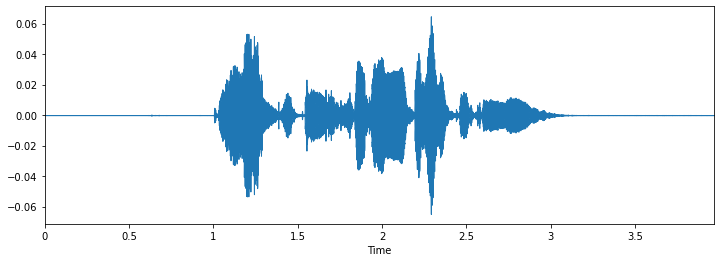

In [43]:
random_sample = EnglishSpeech_df.path[random.randint(0, len(EnglishSpeech_df))]
print("Random audio sample: {}".format(random_sample))
# Dibuja la grafica de la onda sonora
plot_audio_waveform(random_sample)
# Esta es la muestra sonora
ipd.Audio(random_sample, rate=16000)


### **2.2 COMPARATIVA DE TODAS LAS EMOCIONES**
Ahora que hemos conseguido extraer la grafica de una determinada muestra de sonido, vamos a comparar la graficas correspondientes a las muestras de sonido de distintas emociones respectivamente. Para ello vamos a distinguir por genero, ya que podria suponer una diferencia.

In [10]:
def plot_all_emotion_waveforms(gender, rows = 3, cols = 3):
  '''
  Muestra los graficos para todas las emociones con su correspondiente 
  etiqueta del dataset para un mismo genero (female/ male)
  
  Arguments
  --------- 
    gender: str
      Genero del actor en el audio
    rows:  int, optional
      Filas en las que se muestra. 5 por defecto
    cols: int, optional
      Columnas en las que se muestra. 2 por defecto
    
  '''
  labels = list(EnglishSpeech_df['emotion'].unique())
  files = dict()
  if not gender:
    return -1

  # Seleccionamos una muestra aleatoria correspondiente a cada emocion
  for label in labels:
    # Escogemos un archivo de audio al azar que cumpla estas dos condiciones
    index = EnglishSpeech_df[(EnglishSpeech_df['emotion'] == label) & 
                            (EnglishSpeech_df['gender'] == gender)].sample(n = 1).index[0]
    emotion_file = EnglishSpeech_df.iloc[index].path
    files[label] = emotion_file

  # Mostramos las diferentes waveforms
  fig = plt.figure(figsize=(15,15))
  fig.subplots_adjust(hspace=1, wspace=0.4)
  for i, label in enumerate(labels):
    wfigure = files[label]
    fig.add_subplot(rows, cols, i+1)
    plt.title(label.capitalize())
    data_sample, sample_rate = librosa.load(wfigure)
    librosa.display.waveplot(data_sample, sr= sample_rate)

    ## TODO: return image figure


### **2.3 TECNICAS DE _DATA AUGMENTATION_ EN SONIDO**

In [44]:
sample_data = librosa.core.load(random_sample)[0]

### 2.3.1 RUIDO BLANCO
TODO
> - Explicacion ruido blanco
> - Adjust rate spectrum
> - Comparison respective the original. How do they change?

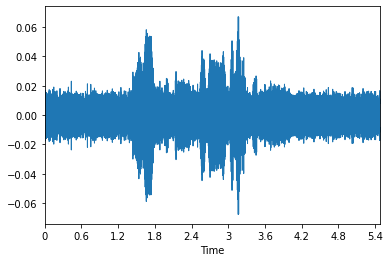

In [45]:

wn_spectrum = np.random.randn(len(sample_data))
data_wn = sample_data + 0.005*wn_spectrum
# plot_audio_waveform(data_wn)
librosa.display.waveplot(data_wn, sr=16000)
ipd.Audio(data_wn, rate=16000)

### 3.2.2 DESPLAZAMIENTO DEL SONIDO

TODO
> [shifting](https://stackoverflow.com/questions/57362543/how-to-properly-use-pitch-shift-librosa)

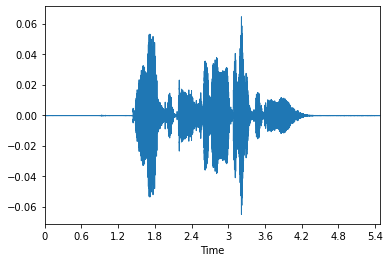

In [48]:
d_range = int(np.random.uniform(low=-5, high = 5)*500) # Optional
# d_range = np.random.uniform(low=1.5, high=3)
data_shiftted = np.roll(sample_data, d_range)
librosa.display.waveplot(data_shiftted, sr=16000)
ipd.Audio(data_shiftted, rate=16000)

### 3.2.3 MODULACION DEL TONO

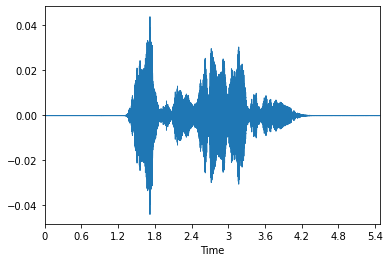

In [47]:
bins_per_octave = 12
pitch_pm = 2
pitch_change =  pitch_pm * 2*(np.random.uniform())   
data_pitch = librosa.effects.pitch_shift(sample_data.astype('float64'),16000, n_steps=pitch_change, bins_per_octave=bins_per_octave)

librosa.display.waveplot(data_pitch, sr=16000)
ipd.Audio(data_pitch, rate=16000)